Date
2024-01-01    242779
2024-01-02    255750
2024-01-03    260443
2024-01-04    260372
2024-01-05    258788
Name: Actual AIL, dtype: int64


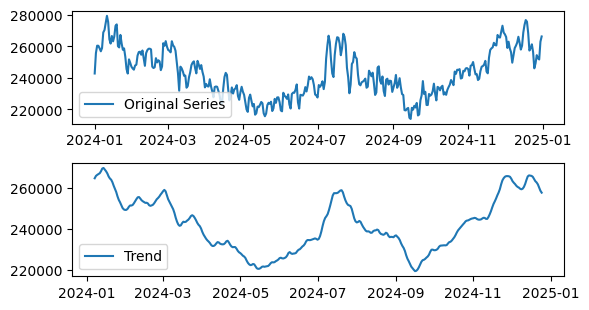

In [3]:
# Demand forecast using SARIMAX model

import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

################### Load Data #####################################
df1 = pd.read_csv('2024ActualForecastData.csv')
df1['Date'] = pd.to_datetime(df1['Date'])
demand_data = df1.groupby(df1['Date'].dt.date)['Actual AIL'].sum()
print(demand_data.head())

# Identify seasonal components
result = seasonal_decompose(demand_data, model='multiplicative', period=12)
trend = result.trend.dropna()
seasonal = result.seasonal.dropna()
residual = result.resid.dropna()

# Plot the decomposed components
plt.figure(figsize=(6,6))

plt.subplot(4, 1, 1)
plt.plot(demand_data, label='Original Series')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend')
plt.legend()

plt.tight_layout()
plt.show()

In [4]:
################################# Stationary Check (ADF test) #######################################
# ADF tests the null hypothesis that there is the existence of a unit root in the time series sample.
# The presence of a unit root implies that the time series is non-stationary, that is, the time series
# does not necessarily have a deterministic trend.

def adftest(dataset):
    try:
        result = adfuller(dataset, autolag='AIC')
        if result[1] < 0.05:
            print('Time Series is Stationary')
        else:
            print('Fail to reject null hypothesis. Time Series is Non-Stationary')
    except Exception as e:
        print('Invalid dataset: {e}')

adftest(demand_data)

Fail to reject null hypothesis. Time Series is Non-Stationary


Time Series is Stationary


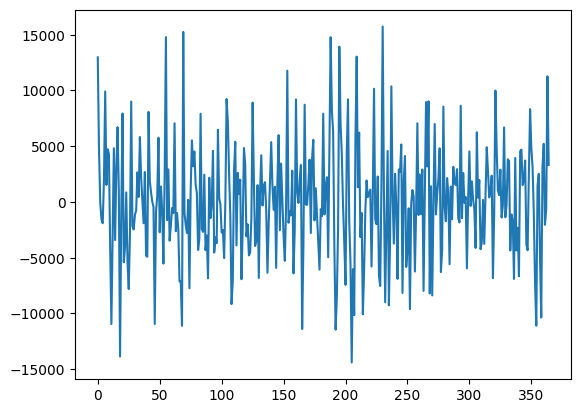

In [5]:
################################ Differencing ##########################################
# Differencing is a method used to transform a non-stationary time series by calculating
# the difference between consecutive observation. y'_t = y_t - y_(t-1)
# It can stabilize the mean of a non-stationary time series by removing changes in
# level of a time series.

def difference(dataset, interval = 1):
    diff = []
    for i in range(interval, len(dataset)):
        diff.append(dataset.iloc[i] - dataset.iloc[i - interval])
    return pd.Series(diff)

adftest(difference(demand_data))
difference(demand_data).plot()
plt.show()



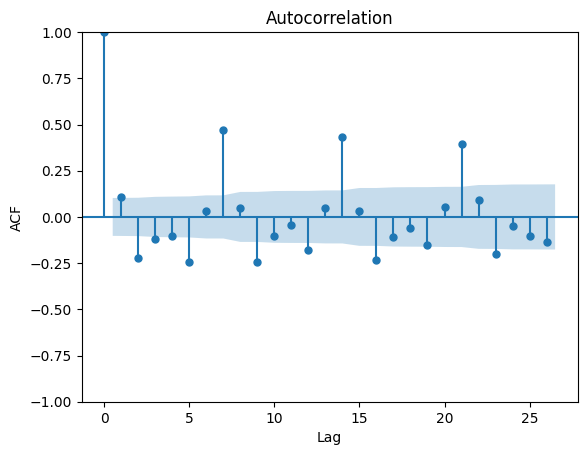

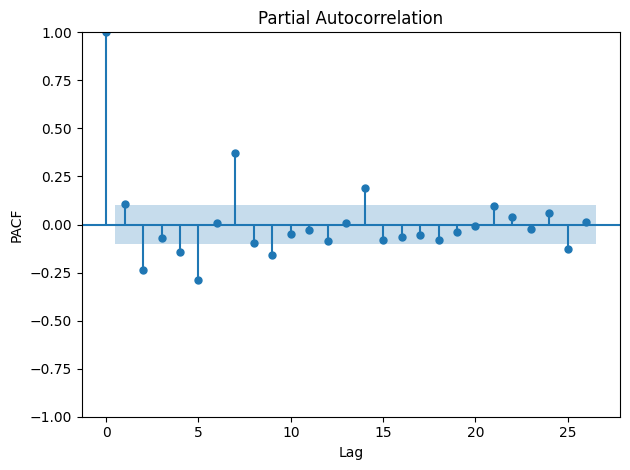

In [6]:
################################### Model Parameter ###########################################
# Autocorrelation function measures how much of the past values (lagged values) affects the current value.
# Partial Autocorrelation function measures how much of the k-th lagged value directly affects the current value.
plot_acf(difference(demand_data))
plt.xlabel('Lag')
plt.ylabel('ACF')

plot_pacf(difference(demand_data))
plt.xlabel('Lag')
plt.ylabel('PACF')

plt.tight_layout()
plt.show()


                                     SARIMAX Results                                     
Dep. Variable:                        Actual AIL   No. Observations:                  347
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -3341.202
Date:                           Tue, 10 Feb 2026   AIC                           6692.403
Time:                                   01:06:34   BIC                           6711.533
Sample:                               01-01-2024   HQIC                          6700.026
                                    - 12-12-2024                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1539      0.675      0.228      0.820      -1.169       1.477
ma.L1         -0.0982      0.687     -0.143

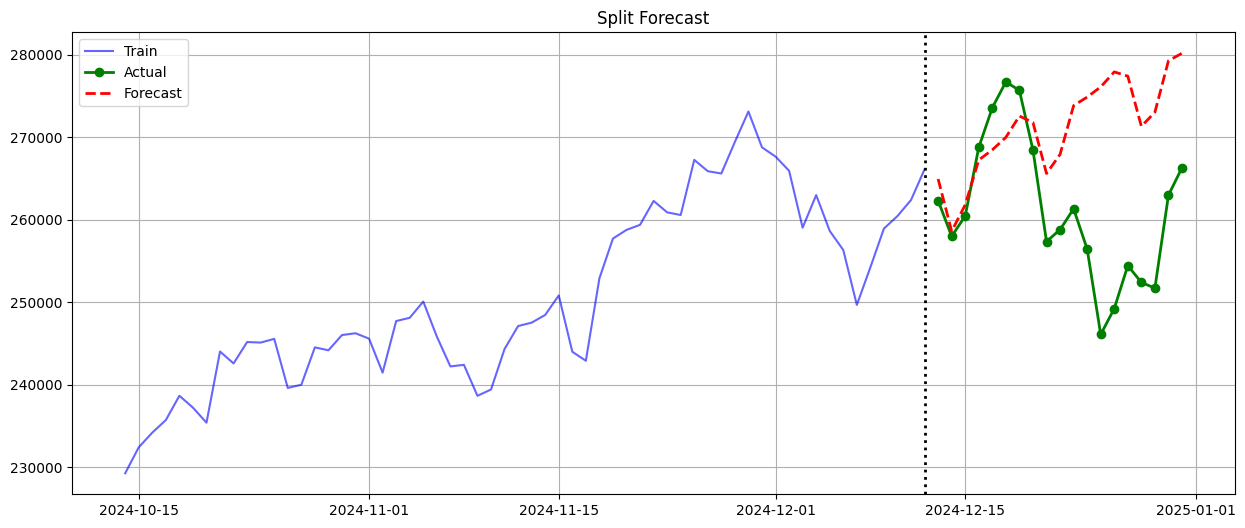


MAE: 11,833


In [8]:
##################### SARIMA Model ######################################
# Model with no exogenous variables
# SARIMAX model can automatically differentiate the non-stationary series, so we can use the
# original data.

# Set the frequency to daily
demand_data = demand_data.asfreq('D')
# Split data for training and testing
def split_point(data, trainSize):
    """
    :param data: Time Series DataFrame
    :param trainSize: Training set size proportion ie 80% of series is used for training
    :return: train data, test data
    """
    split_ind = int(len(data) * trainSize)
    train = data[:split_ind]
    test = data[split_ind:]
    return train, test

train, test = split_point(demand_data, 0.95)
model1 = SARIMAX(
    train,
    order = (1, 1, 1),
    seasonal_order = (1, 1, 1, 7)
)
results1 = model1.fit()
print(results1.summary())

forecast = results1.forecast(steps=len(test))
forecast.index = test.index

# Plot
plt.figure(figsize=(15, 6))
plt.plot(train.index[-60:], train.values[-60:], 'b-', label='Train', alpha=0.6)
plt.plot(test.index, test.values, 'go-', label='Actual', linewidth=2)
plt.plot(forecast.index, forecast.values, 'r--', label='Forecast', linewidth=2)
plt.axvline(train.index[-1], color='black', linestyle=':', linewidth=2)
plt.legend()
plt.title('Split Forecast')
plt.grid(True)
plt.show()

# Accuracy
from sklearn.metrics import mean_absolute_error
print(f"\nMAE: {mean_absolute_error(test, forecast):,.0f}")


                0      1      2      3      4      5      6
Date                                                       
2024-01-01   True  False  False  False  False  False  False
2024-01-02  False   True  False  False  False  False  False
2024-01-03  False  False   True  False  False  False  False
2024-01-04  False  False  False   True  False  False  False
2024-01-05  False  False  False  False   True  False  False
                               SARIMAX Results                                
Dep. Variable:             Actual AIL   No. Observations:                  347
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -3352.122
Date:                Tue, 10 Feb 2026   AIC                           6724.244
Time:                        01:06:40   BIC                           6762.708
Sample:                    01-01-2024   HQIC                          6739.561
                         - 12-12-2024                                         
Covariance Type:           

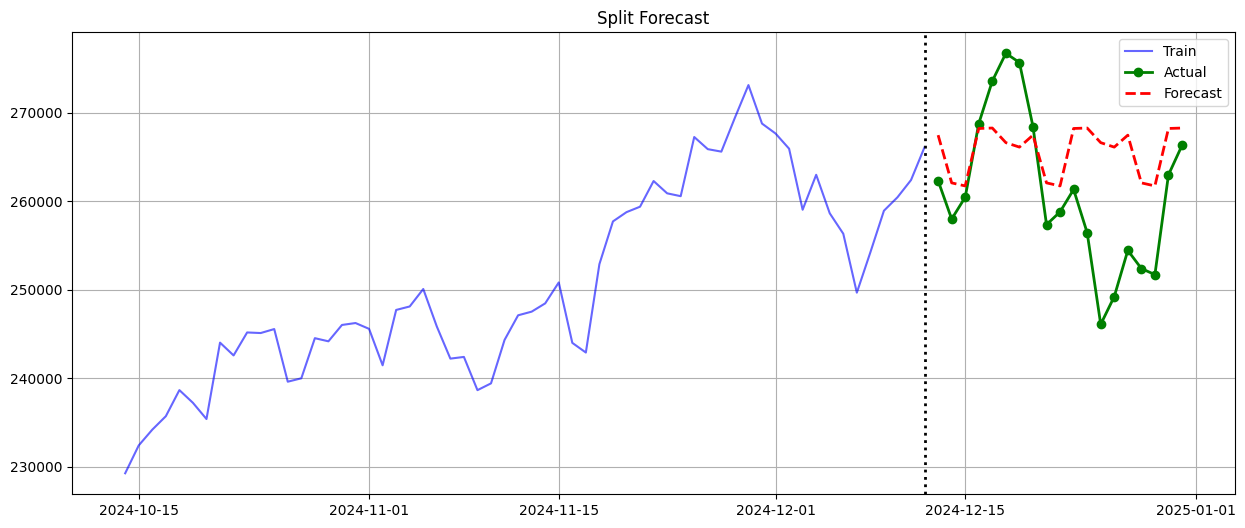


MAE: 7,407


In [9]:
############################# SARIMAX Model #####################################
# Model with day of the week as an exogenous variable

# Extract Exogenous Variables
def dayVar(data):
    df = pd.DataFrame(index=data.index)
    df['Day'] = data.index.dayofweek

    # Dummy variable
    dayDum = pd.get_dummies(df['Day'])
    return dayDum

print(dayVar(demand_data).head())

train, test = split_point(demand_data, 0.95)
# Create exog data
exog_train = dayVar(train)
exog_test = dayVar(test)

model2 = SARIMAX(
    train,
    exog=exog_train,
    order = (1, 1, 1)
)

results2 = model2.fit()
print(results2.summary())

# Forecast
forecast2 = results2.forecast(steps=len(test), exog=exog_test)
forecast2.index = test.index

# Plot
plt.figure(figsize=(15, 6))
plt.plot(train.index[-60:], train.values[-60:], 'b-', label='Train', alpha=0.6)
plt.plot(test.index, test.values, 'go-', label='Actual', linewidth=2)
plt.plot(forecast2.index, forecast2.values, 'r--', label='Forecast', linewidth=2)
plt.axvline(train.index[-1], color='black', linestyle=':', linewidth=2)
plt.legend()
plt.title('Split Forecast')
plt.grid(True)
plt.show()

# Accuracy
from sklearn.metrics import mean_absolute_error
print(f"\nMAE: {mean_absolute_error(test, forecast2):,.0f}")
